In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

EJ = 12
EC = 0.3
ng = 0
N = 2

n_vals = np.arange(-N, N+1)
dim_qubit = len(n_vals)

n_op = Qobj(np.diag(n_vals), dims=[[dim_qubit], [dim_qubit]])
shift_right = Qobj(np.diag(np.ones(dim_qubit - 1), 1), dims=[[dim_qubit], [dim_qubit]])
shift_left = shift_right.dag()
cos_phi = (shift_right + shift_left) / 2

H_transmon = 4 * EC * (n_op - ng)**2 - EJ * cos_phi

eigenenergies = H_transmon.eigenenergies()

print("Transmon energy levels:")
for i, E in enumerate(eigenenergies[:3]):
    print(f"Level {i}: {E:.4f} GHz")

f01_a = eigenenergies[1] - eigenenergies[0]
f12 = eigenenergies[2] - eigenenergies[1]
print(f"\nf01 = {f01_a:.4f} GHz")
print(f"f12 = {f12:.4f} GHz")
print(f"Anharmonicity = {f12 - f01_a:.4f} GHz")

Transmon energy levels:
Level 0: -9.1988 GHz
Level 1: -3.2642 GHz
Level 2: 3.1071 GHz

f01 = 5.9346 GHz
f12 = 6.3713 GHz
Anharmonicity = 0.4367 GHz


In [4]:
omega_r = 7 
n_res = 10
a = destroy(n_res)
H_resonator = omega_r * a.dag() * a

H_total = tensor(H_transmon, qeye(n_res)) + tensor(qeye(dim_qubit), H_resonator)

g = 0.005

evals, evecs = H_transmon.eigenstates()
proj_01 = evecs[0] * evecs[1].dag()
H_int = g * (tensor(proj_01.dag(), a) + tensor(proj_01, a.dag()))

H_total += H_int

eigenenergies_coupled = H_total.eigenenergies()

print("Hybridized energy levels (lowest 6):")
for i, E in enumerate(eigenenergies_coupled[:6]):
    print(f"Level {i}: {E:.4f} GHz")

f01_b = eigenenergies_coupled[1] - eigenenergies_coupled[0]
f12 = eigenenergies_coupled[2] - eigenenergies_coupled[1]
anharmonicity = f12 - f01_b

print(f"\nQubit transition frequency f01: {f01_b:.4f} GHz")
print(f"Second transition frequency f12: {f12:.4f} GHz")
print(f"Anharmonicity (f12 - f01): {anharmonicity:.4f} GHz")

Hybridized energy levels (lowest 6):
Level 0: -9.1988 GHz
Level 1: -3.2642 GHz
Level 2: -2.1988 GHz
Level 3: 3.1071 GHz
Level 4: 3.7358 GHz
Level 5: 4.8013 GHz

Qubit transition frequency f01: 5.9346 GHz
Second transition frequency f12: 1.0655 GHz
Anharmonicity (f12 - f01): -4.8691 GHz


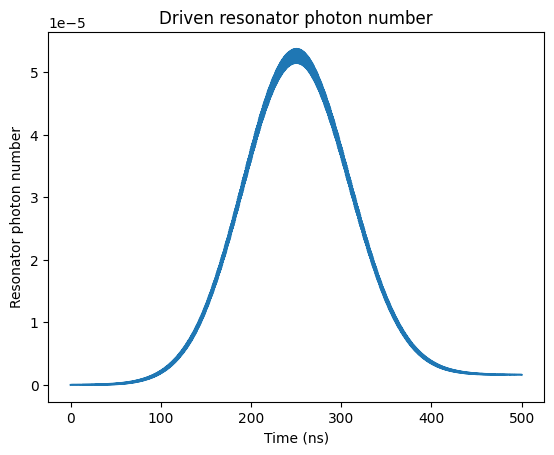

In [9]:
drive_amp = 0.05        
drive_freq = omega_r     
drive_duration = 500    
tlist = np.linspace(0, drive_duration, 5000)

def gaussian_pulse(t, args):
    t0 = drive_duration / 2
    sigma = drive_duration / 6
    return drive_amp * np.exp(-(t - t0)**2 / (2 * sigma**2))

H_drive = [tensor(qeye(dim_qubit), a + a.dag()), gaussian_pulse]

psi0 = tensor(H_transmon.groundstate()[1], basis(n_res, 0))

c_ops = []

H_qubit = tensor(H_transmon, qeye(n_res))
H_res = tensor(qeye(dim_qubit), H_resonator)
H_full = H_qubit + H_res + H_int

drive_op = tensor(qeye(dim_qubit), a + a.dag())

H_total = [H_full, [drive_op, gaussian_pulse]]


result = mesolve(H_total, psi0, tlist, c_ops, [tensor(qeye(dim_qubit), a.dag() * a)])

plt.plot(tlist, result.expect[0])
plt.xlabel('Time (ns)')
plt.ylabel('Resonator photon number')
plt.title('Driven resonator photon number')
plt.show()